# Load r, b, g, and nir, corrected for no data pixels, cloud, and image overlap

This notebook does something.

(46, 473, 484)
(473, 484, 1)


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


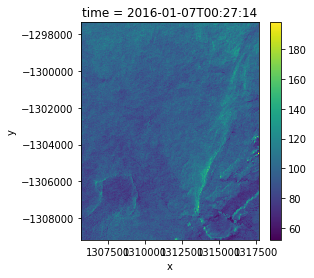

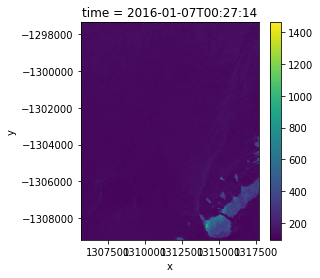

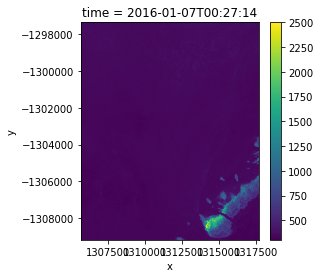

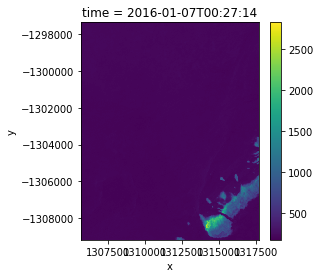

In [2]:
%matplotlib inline
import datacube
dc = datacube.Datacube(app='load-data-example')

#Load data for a specified area and time grouped by solar day
data = dc.load(product='ls8_nbar_albers', 
               x=(143.76, 143.86), y=(-11.75, -11.85),
               time=('2016-01-01', '2017-01-01'), group_by='solar_day')

#Define which image to work on in the given time range
image=0

#Define variables
nir = data.nir.isel(time=image)
red = data.red.isel(time=image)
blue = data.blue.isel(time=image)
green = data.green.isel(time=image)

#Find out how many images are available
print(data.nir.shape)

#Remove no data pixels and plot images with clouds
nir_valid = nir.where(nir != nir.attrs['nodata'])
red_valid = red.where(red != red.attrs['nodata'])
blue_valid = blue.where(blue != blue.attrs['nodata'])
green_valid = green.where(green != green.attrs['nodata'])

#wave1_valid.plot(figsize=(4,4))

#Load pixel quality data for the same area and time
pq = dc.load(product='ls8_pq_albers', 
               x=(143.76, 143.86), y=(-11.75, -11.85),
               time=('2016-01-01', '2017-01-01'), group_by='solar_day')
pq_toplot = pq.pixelquality

#Create a dataframe for masking bad data
from datacube.storage import masking
import pandas
pandas.DataFrame.from_dict(masking.get_flags_def(pq), orient='index')

#Mask out the bad data
good_data = masking.make_mask(pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', contiguous=True)
toplot_good_data = good_data.pixelquality

#Apply the mask to give good data with clouded pixels represented by NaN
nir_cloud_free = nir_valid.where(toplot_good_data)
red_cloud_free = red_valid.where(toplot_good_data)
blue_cloud_free = blue_valid.where(toplot_good_data)
green_cloud_free = green_valid.where(toplot_good_data)
#wave1_cloud_free.isel(time=image).plot(figsize=(4,4))

#Find only the images in the time series that are cloud free, then return the number of cloud-free images and display the
# image for the specified time
cloud_free = masking.make_mask(pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', contiguous=True).pixelquality
only_cloud_free = cloud_free.mean(dim=('x','y')) == 1
nir_only_cloud_free = nir_cloud_free.where(only_cloud_free).dropna('time', how='all')
red_only_cloud_free = red_cloud_free.where(only_cloud_free).dropna('time', how='all')
blue_only_cloud_free = blue_cloud_free.where(only_cloud_free).dropna('time', how='all')
green_only_cloud_free = green_cloud_free.where(only_cloud_free).dropna('time', how='all')
print (nir_only_cloud_free.shape)
nir_only_cloud_free.isel(time=image).plot(figsize=(4,4))
red_only_cloud_free.isel(time=image).plot(figsize=(4,4))
blue_only_cloud_free.isel(time=image).plot(figsize=(4,4))
green_only_cloud_free.isel(time=image).plot(figsize=(4,4))

# Identify glint

## Plot r,b, or g against nir and calculate a linear best fit line

red gradient:    0.906222606258
red y-intercept: 40.5956523642
blue gradient:    1.32734531673
blue y-intercept: 217.205313632
green gradient:    1.05282101661
green y-intercept: 115.431994074


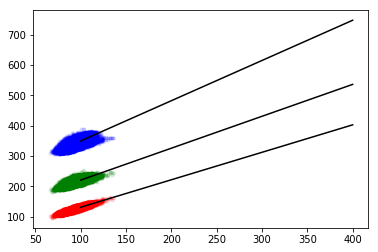

In [3]:
import numpy as np
import matplotlib.pyplot as plt

#Define x and y for plotting as 1D arrays - WHERE ALL DEEP OCEAN
# x = np.hstack(nir_only_cloud_free.isel(time=image))
# y1 = np.hstack(red_only_cloud_free.isel(time=image))
# y2 = np.hstack(blue_only_cloud_free.isel(time=image))
# y3 = np.hstack(green_only_cloud_free.isel(time=image))

#Define x and y for plotting as 1D arrays - WHERE PARTIALLY DEEP OCEAN
x = np.hstack(nir_only_cloud_free.isel(x=slice(0,200), time=image))
y1 = np.hstack(red_only_cloud_free.isel(x=slice(0,200), time=image))
y2 = np.hstack(blue_only_cloud_free.isel(x=slice(0,200), time=image))
y3 = np.hstack(green_only_cloud_free.isel(x=slice(0,200), time=image))

#Calculate linear best fit line
from sklearn.linear_model import LinearRegression
red_model = LinearRegression()
blue_model = LinearRegression()
green_model = LinearRegression()

red_model.fit(x[:, np.newaxis], y1)
blue_model.fit(x[:, np.newaxis], y2)
green_model.fit(x[:, np.newaxis], y3)

#Define x and y values for the best fit line
xfit = np.linspace(100,400)
y1fit = red_model.predict(xfit[:, np.newaxis])
y2fit = blue_model.predict(xfit[:, np.newaxis])
y3fit = green_model.predict(xfit[:, np.newaxis])

#Plot the data and the best fit line
plt.scatter(x, y1, s = 10, color = 'red', alpha = 0.1)
plt.plot(xfit, y1fit, color = 'black')

plt.scatter(x, y2, s = 10, color = 'blue', alpha = 0.1)
plt.plot(xfit, y2fit, color = 'black')

plt.scatter(x, y3, s = 10, color = 'green', alpha = 0.1)
plt.plot(xfit, y3fit, color = 'black')

#Print gradient and y-intercept
print("red gradient:   ", red_model.coef_[0])
print("red y-intercept:", red_model.intercept_)

print("blue gradient:   ", blue_model.coef_[0])
print("blue y-intercept:", blue_model.intercept_)

print("green gradient:   ", green_model.coef_[0])
print("green y-intercept:", green_model.intercept_)

## Calculate and plot the degree of glint for each pixel

<xarray.DataArray (y: 473, x: 484)>
array([[ 70.175718,  71.525251,  74.224317, ...,  74.224317,  79.622449,
         79.622449],
       [ 71.525251,  74.224317,  75.57385 , ...,  70.175718,  82.321515,
         78.272916],
       [ 67.476652,  70.175718,  70.175718, ...,  70.175718,  78.272916,
         70.175718],
       ..., 
       [ 43.185057,  35.087859,  33.738326, ...,  48.583189,  45.884123,
         51.282255],
       [ 43.185057,  39.136458,  37.786925, ...,  44.53459 ,  41.835524,
         47.233656],
       [ 43.185057,  41.835524,  43.185057, ...,  41.835524,  39.136458,
         41.835524]])
Coordinates:
    time     datetime64[ns] 2016-01-07T00:27:14
  * y        (y) float64 -1.297e+06 -1.297e+06 -1.297e+06 -1.297e+06 ...
  * x        (x) float64 1.306e+06 1.306e+06 1.306e+06 1.306e+06 1.306e+06 ...


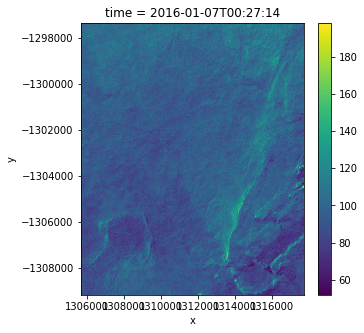

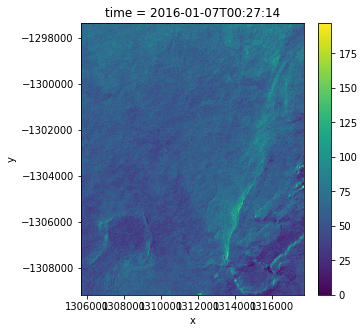

In [4]:
#Proxy for glint: degree_of_glint = absolute length of line parallel to slope of best fit line (above). 
#This is found using trig - first term is distance between pixel value and min(nir) along x-axis,
#second term is the cosine of the angle between horizontal and best fit line

degree_of_glint = ((nir_only_cloud_free.isel(time=image))-(nir_only_cloud_free.isel(time=image).min()))/np.cos(np.deg2rad(np.rad2deg(np.arctan(red_model.coef_[0]))))
print(degree_of_glint)
#Plot map of degree of glint
nir_only_cloud_free.isel(time=image).plot(figsize=(5,5))
degree_of_glint.plot(figsize=(5,5))

# Correct for glint in r,g,b using the Hedley method

In [24]:
#Apply the Hedley correction to the cloud free data for each wavelenght
red_corr = red_only_cloud_free.isel(time=image)-((red_model.coef_[0])*((nir_only_cloud_free.isel(time=image))-(nir_only_cloud_free.isel(x=slice(0,200),time=image).min())))
blue_corr = blue_only_cloud_free.isel(time=image)-((blue_model.coef_[0])*((nir_only_cloud_free.isel(time=image))-(nir_only_cloud_free.isel(x=slice(0,200),time=image).min())))
green_corr = green_only_cloud_free.isel(time=image)-((green_model.coef_[0])*((nir_only_cloud_free.isel(time=image))-(nir_only_cloud_free.isel(x=slice(0,200),time=image).min())))
print (red_corr)

<xarray.DataArray (y: 473, x: 484)>
array([[ 106.563541,  107.657318,  103.844873, ...,  105.844873,  104.219983,
          99.219983],
       [ 103.657318,  106.844873,  103.938651, ...,  107.563541,  101.407538,
         100.126205],
       [ 101.375986,  103.563541,  101.563541, ...,  106.563541,  100.126205,
         100.563541],
       ..., 
       [  97.687993,  101.125329,  101.031551, ...,  103.063103,  103.875548,
          99.250657],
       [  96.687993,  100.406661,  103.312884, ...,  101.78177 ,  102.594216,
          98.969325],
       [  99.687993,  102.594216,  101.687993, ...,   96.594216,  101.406661,
         101.594216]])
Coordinates:
    time     datetime64[ns] 2016-01-07T00:27:14
  * y        (y) float64 -1.297e+06 -1.297e+06 -1.297e+06 -1.297e+06 ...
  * x        (x) float64 1.306e+06 1.306e+06 1.306e+06 1.306e+06 1.306e+06 ...


In [25]:
#Create nir_corr - an array of the same shape as nir_only_cloud_free (etc.) where all values equal nir_only_cloud_free.min()
nir_corr = red_corr/red_corr*nir_only_cloud_free.isel(x=slice(0,200),time=image).min()

# Plot wavelength v intensity

## For one column or row of pixels in an area

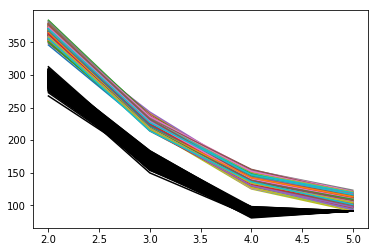

In [7]:
#Select an x range, y-value and time to look at pixels from
pixels = data.isel(x=slice(0,470),y=10,time=0)

#Create a horizontal 1D array for the Landsat bands
landsat_bands = np.array([2,3,4,5])

#Plot r,g,b,nir bands v intensity for all pixels in x range (raw, raw cloud free, and corrected)
for i in range (470):
    #plt.plot(landsat_bands,np.vstack((pixels.blue, pixels.green, pixels.red, pixels.nir))[:,i])
    plt.plot(landsat_bands,np.vstack((blue_only_cloud_free.isel(x=slice(0,470),y=10,time=image), green_only_cloud_free.isel(x=slice(0,470),y=10,time=image), red_only_cloud_free.isel(x=slice(0,470),y=10,time=image), nir_only_cloud_free.isel(x=slice(0,470),y=10,time=image)))[:,i])
    plt.plot(landsat_bands,np.vstack((blue_corr.isel(x=slice(0,470),y=10), green_corr.isel(x=slice(0,470),y=10), red_corr.isel(x=slice(0,470),y=10), nir_corr.isel(x=slice(0,470),y=10)))[:,i], color = 'black')

## For max and min nir intensities in the area

In [26]:
#Take the uncorrected data, and sepeartely the corrected data, and create an array for each, where each band and degree of 
#glint values are stacked into 1D arrays and then transposed to create a 2D array. 

#Uncorrected data:
nir_uncorr_stacked = np.hstack(nir_only_cloud_free.isel(x=slice(0,200),time=image))
red_uncorr_stacked = np.hstack(red_only_cloud_free.isel(x=slice(0,200),time=image))
blue_uncorr_stacked = np.hstack(blue_only_cloud_free.isel(x=slice(0,200),time=image))
green_uncorr_stacked = np.hstack(green_only_cloud_free.isel(x=slice(0,200),time=image))
degree_of_glint_stacked = np.hstack(degree_of_glint.isel(x=slice(0,200)))
all_uncorr = np.transpose(np.vstack((blue_uncorr_stacked, green_uncorr_stacked, red_uncorr_stacked, nir_uncorr_stacked, degree_of_glint_stacked)))
print (all_uncorr)

#Corrected data:
nir_corr_stacked = np.hstack(nir_corr.isel(x=slice(0,200)))
red_corr_stacked = np.hstack(red_corr.isel(x=slice(0,200)))
blue_corr_stacked = np.hstack(blue_corr.isel(x=slice(0,200)))
green_corr_stacked = np.hstack(green_corr.isel(x=slice(0,200)))
degree_of_glint_stacked = np.hstack(degree_of_glint.isel(x=slice(0,200)))
all_corr = np.transpose(np.vstack((blue_corr_stacked, green_corr_stacked, red_corr_stacked, nir_corr_stacked, degree_of_glint_stacked)))
print (all_corr)

[[ 366.          231.          141.          104.           70.17571781]
 [ 364.          232.          143.          105.           71.52525085]
 [ 359.          233.          141.          107.           74.22431692]
 ..., 
 [ 337.          212.          127.           96.           59.37945353]
 [ 332.          210.          127.           96.           59.37945353]
 [ 335.          212.          128.           95.           58.0299205 ]]
[[ 315.56087796  190.99280137  106.56354096   66.           70.17571781]
 [ 312.23353265  190.93998035  107.65731836   66.           71.52525085]
 [ 304.57884201  189.83433832  103.84487314   66.           74.22431692]
 ..., 
 [ 297.1796405   180.4153695    99.81332181   66.           59.37945353]
 [ 292.1796405   178.4153695    99.81332181   66.           59.37945353]
 [ 296.50698581  181.46819052  101.71954442   66.           58.0299205 ]]


In [27]:
#order the rows of the two matricies from min-max degree_of_glint
all_uncorr_ordered = all_uncorr[all_uncorr[:,4].argsort()]
all_corr_ordered = all_corr[all_corr[:,4].argsort()]
print (all_uncorr_ordered)
print (all_corr_ordered)

#Check that the ordering has worked by finding the max nir value in all_corr and seeing what thr rgb values are for 
#that pixel
all_corr[np.where(all_corr[:,4] == all_corr[:,4].max())]

[[ 310.          188.          103.           66.           18.89346249]
 [ 316.          195.          101.           67.           20.24299552]
 [ 314.          182.           96.           68.           21.59252856]
 ..., 
 [ 359.          237.          156.          134.          110.66170886]
 [ 360.          243.          162.          136.          113.36077493]
 [ 360.          243.          162.          136.          113.36077493]]
[[ 310.          188.          103.           66.           18.89346249]
 [ 314.67265468  193.94717898  100.09377739   66.           20.24299552]
 [ 311.34530937  179.89435797   94.18755479   66.           21.59252856]
 ..., 
 [ 268.74051846  165.40817087   94.37686277   66.          110.66170886]
 [ 267.08582783  169.30252884   98.56441756   66.          113.36077493]
 [ 267.08582783  169.30252884   98.56441756   66.          113.36077493]]


array([[ 267.08582783,  169.30252884,   98.56441756,   66.        ,
         113.36077493],
       [ 267.08582783,  169.30252884,   98.56441756,   66.        ,
         113.36077493]])

In [28]:
#Take to values from each of the two matricies where degree_of_glint values are lowest and highest. 
minmax_uncorr = np.vstack(((all_uncorr_ordered[:100,:4]),(all_uncorr_ordered[-100:,:4])))
minmax_corr = np.vstack(((all_corr_ordered[:100,:4]),(all_corr_ordered[-100:,:4])))
print (minmax_uncorr)

[[ 310.  188.  103.   66.]
 [ 316.  195.  101.   67.]
 [ 314.  182.   96.   68.]
 [ 315.  189.  104.   68.]
 [ 321.  187.  100.   68.]
 [ 315.  188.  103.   68.]
 [ 314.  182.   96.   68.]
 [ 317.  189.   99.   68.]
 [ 315.  188.  102.   69.]
 [ 320.  190.  105.   69.]
 [ 313.  187.  102.   69.]
 [ 311.  189.  101.   69.]
 [ 310.  187.  105.   70.]
 [ 314.  190.  102.   70.]
 [ 318.  192.  105.   70.]
 [ 312.  185.  102.   70.]
 [ 320.  191.  109.   70.]
 [ 320.  188.  103.   70.]
 [ 315.  196.  108.   71.]
 [ 311.  184.   98.   71.]
 [ 316.  193.  107.   71.]
 [ 319.  195.  108.   71.]
 [ 318.  196.  110.   71.]
 [ 314.  192.  106.   71.]
 [ 318.  189.  100.   71.]
 [ 317.  192.  105.   71.]
 [ 319.  191.  107.   71.]
 [ 314.  189.  106.   71.]
 [ 318.  193.   98.   71.]
 [ 308.  196.  108.   71.]
 [ 317.  193.  105.   71.]
 [ 321.  196.  105.   71.]
 [ 326.  197.  109.   71.]
 [ 318.  192.  102.   71.]
 [ 317.  195.  106.   72.]
 [ 322.  195.  110.   72.]
 [ 316.  188.  105.   72.]
 

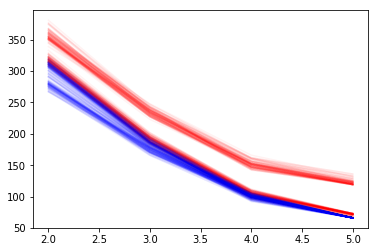

In [41]:
#Plot both the uncorrected data (red) and the corrected data (black)
for i in range (200):
    plt.plot(landsat_bands, (np.transpose(minmax_corr))[:,i], color = 'blue', alpha = 0.05)
    plt.plot(landsat_bands, (np.transpose(minmax_uncorr))[:,i], color = 'red', alpha = 0.05)


# Load true-colour images to show glint removal

Bex's colour notebook
https://github.com/GeoscienceAustralia/dea-notebooks/blob/BexDunn/workflows/Retrieve_Landsat_plot_false_color_190218.ipynb

Other websites from Bex:
All about colour things in scikit... http://scikit-image.org/docs/dev/user_guide/transforming_image_data.html
Loading colours in GDAL: https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html#clip-a-geotiff-with-shapefile
Random colour-related things:
https://stackoverflow.com/questions/42991524/how-to-optimize-this-image-iteration-in-numpy
https://www.programcreek.com/python/example/71304/cv2.COLOR_BGR2RGB

## Create datasets from data arrays

In [30]:
import xarray as xr

#Create a dataset of rgb only_cloud_free.isel(time=image) data arrays
red_only_cloud_free = xr.DataArray(red_only_cloud_free.isel(time=image), name = 'red_only_cloud_free')
blue_only_cloud_free = xr.DataArray(blue_only_cloud_free.isel(time=image), name = 'blue_only_cloud_free')
green_only_cloud_free = xr.DataArray(green_only_cloud_free.isel(time=image), name = 'green_only_cloud_free')
dataset_only_cloud_free = xr.merge([red_only_cloud_free, green_only_cloud_free, blue_only_cloud_free])


#Create a dataset of rgb corr data arrays
red_corr = xr.DataArray(red_corr, name = 'red_corr')
blue_corr = xr.DataArray(blue_corr, name = 'blue_corr')
green_corr = xr.DataArray(green_corr, name = 'green_corr')
dataset_corr = xr.merge([red_corr, green_corr, blue_corr])

## Plot true-colour images with and without glint

AttributeError: 'numpy.ndarray' object has no attribute 'isel'

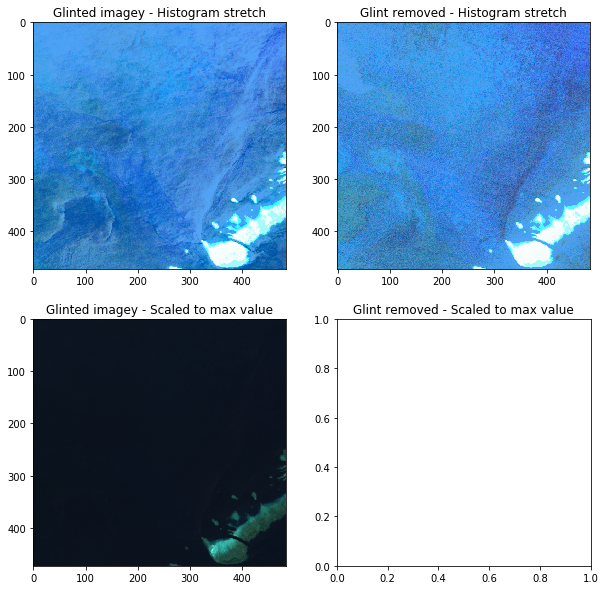

In [47]:
from matplotlib.pyplot import imshow
from skimage import exposure

#HISTOGRAM STRETCH IMAGES
#Draw image with sun glint
def drawTrueColourHist(ds):
    '''this function takes the shape of an input band and uses swir1, nir and green to make and display a false
    color composite. Written by Mike Barnes, edited by Bex Dunn and Claire Krause'''
    y, x = ds['red_only_cloud_free'].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(['red_only_cloud_free', 'green_only_cloud_free', 'blue_only_cloud_free']):
        rawimg[:,:,i] = ds[colour].values
    rawimg[rawimg == -999] = np.nan
    img_toshow1 = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    return img_toshow1


#Draw image with no sun glint
def drawTrueColourNoGlintHist(ds):
    '''this function takes the shape of an input band and uses swir1, nir and green to make and display a false
    color composite. Written by Mike Barnes, edited by Bex Dunn and Claire Krause'''
    y, x = ds['red_corr'].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(['red_corr', 'green_corr', 'blue_corr']):
        rawimg[:,:,i] = ds[colour].values
    rawimg[rawimg == -999] = np.nan
    img_toshow2 = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    return img_toshow2

#SCALED TO MAX VAL IMAGES
#Draw image with sun glint
def drawTrueColourScaled(ds):
    '''this function takes the shape of an input band and uses swir1, nir and green to make and display a false
    color composite. Written by Mike Barnes, edited by Bex Dunn and Claire Krause'''
    y, x = ds['red_only_cloud_free'].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(['red_only_cloud_free', 'green_only_cloud_free', 'blue_only_cloud_free']):
        rawimg[:,:,i] = ds[colour].values
    rawimg[rawimg == -999] = np.nan
    img_toshow3 = rawimg/rawimg.max()
    return img_toshow3

#Draw image with no sun glint
def drawTrueColourNoGlintScaled(ds):
    '''this function takes the shape of an input band and uses swir1, nir and green to make and display a false
    color composite. Written by Mike Barnes, edited by Bex Dunn and Claire Krause'''
    y, x = ds['red_corr'].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(['red_corr', 'green_corr', 'blue_corr']):
        rawimg[:,:,i] = ds[colour].values
    rawimg[rawimg == -999] = np.nan
    img_toshow4 = rawimg/rawimg.max()
    return img_toshow4


#Plot rgb glinted images and rgb images with glint removed, using a histogram stretch and by scaling intensities to maximum values
plt.figure(figsize = (10,10))
plt.subplot(221)
plt.title ('Glinted imagey - Histogram stretch')
imshow(drawTrueColourHist(dataset_only_cloud_free))
plt.subplot(222)
plt.title('Glint removed - Histogram stretch')
imshow(drawTrueColourNoGlintHist(dataset_corr))
plt.subplot(223)
plt.title ('Glinted imagey - Scaled to max value')
imshow(drawTrueColourScaled(dataset_only_cloud_free))
plt.subplot(224)
plt.title('Glint removed - Scaled to max value')
imshow(drawTrueColourNoGlintScaled(dataset_corr))